# DBSCAN
DBSCAN группирует точки по плотности. Точка является core, если в ее $\varepsilon$-окрестности $N_\varepsilon(x)$ находится как минимум $\text{min\_samples}$ точек. Кластеры формируются из всех точек, достижимых по плотности, а точки, не относящиеся ни к одному кластеру, помечаются как шум. Метод не требует заранее задавать число кластеров и хорошо выделяет кластеры произвольной формы.


## Используемые библиотеки
Используем `numpy`, `pandas`, `seaborn`, `matplotlib`. Из `sklearn` — `make_moons` для нелинейных кластеров, `StandardScaler`, `DBSCAN`, `silhouette_score`.


In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score


In [18]:
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.dpi"] = 120
PRIMARY_COLOR = "#1f77b4"
HEATMAP_CMAP = "coolwarm"


## Датасет: описание и частичная распечатка
Синтетический датасет **make_moons** — 400 точек двух «лунообразных» кластеров с шумом (`noise=0.08`). Этот датасет специально создан для демонстрации преимущества DBSCAN над k-means: k-means не может правильно разделить нелинейные («банановые») кластеры, а DBSCAN справляется за счёт анализа локальной плотности.


In [19]:
X, _ = make_moons(n_samples=400, noise=0.08, random_state=42)

data = pd.DataFrame(X, columns=["feature_1", "feature_2"])
print(f"Размерность: {data.shape}")
data.head()


Размерность: (400, 2)


,feature_1,feature_2
0,-0.033226,0.420541
1,0.693183,-0.411493
2,0.836026,0.532761
3,0.145537,0.283647
4,0.093859,0.955842


## Предварительная обработка
Стандартизируем данные. Параметры `eps` и `min_samples` в DBSCAN задаются в пространстве признаков, поэтому их значения зависят от масштаба данных. После `StandardScaler` оба признака имеют единичный масштаб, что делает `eps=0.3` интерпретируемым.


In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)


## Тепловая карта корреляций
Для «лунообразных» данных корреляция Пирсона не отражает нелинейную структуру — метрика может быть близка к нулю даже при явной нелинейной зависимости. Это иллюстрирует ограниченность линейных метрик: корреляция ≈ 0 не означает независимость.


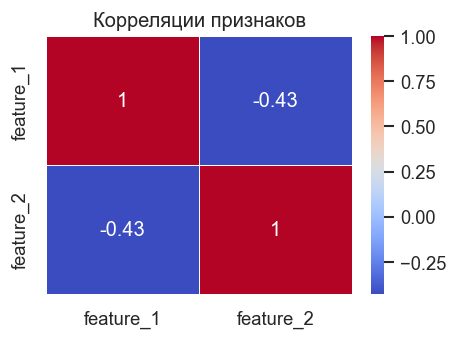

In [21]:
plt.figure(figsize=(4, 3))
correlation = data.corr()
sns.heatmap(correlation, annot=True, cmap=HEATMAP_CMAP, linewidths=0.5)
plt.title("Корреляции признаков")
plt.tight_layout()
plt.show()


## Обучение модели
`DBSCAN(eps=0.3, min_samples=5)`. Точки с метками `-1` — шум. `eps=0.3` — радиус поиска соседей, `min_samples=5` — минимальное число точек для объявления core-точки. Эти параметры подобраны вручную; для автовыбора используют k-distance graph или `GridSearchCV` по silhouette.


In [22]:
model = DBSCAN(eps=0.3, min_samples=5)
model.fit(X_scaled)


DBSCAN(eps=0.3)

## Прогнозы модели
Выводим число найденных кластеров и Silhouette Score без учёта шума. Для хорошо разделённых лун ожидаем 2 кластера и высокий силуэт (> 0.5). Точки-шум — выбросы на границах двух лун.


In [23]:
labels = model.labels_

cluster_labels = labels[labels >= 0]
if len(np.unique(cluster_labels)) > 1:
    score = silhouette_score(X_scaled[labels >= 0], cluster_labels)
else:
    score = float("nan")

print("DBSCAN")
print(f"Clusters: {len(np.unique(cluster_labels))}")
print(f"Silhouette (без шума): {score:.3f}")


DBSCAN
Clusters: 2
Silhouette (без шума): 0.376


## Графики выходных результатов
**Scatter-график.** Каждый кластер — свой цвет, шум — чёрный. Идеально: две окрашенные «луны» и минимум чёрных точек. Увеличение `eps` уменьшает шум, но может слить два кластера; уменьшение `min_samples` расширяет кластеры за счёт пограничных точек.


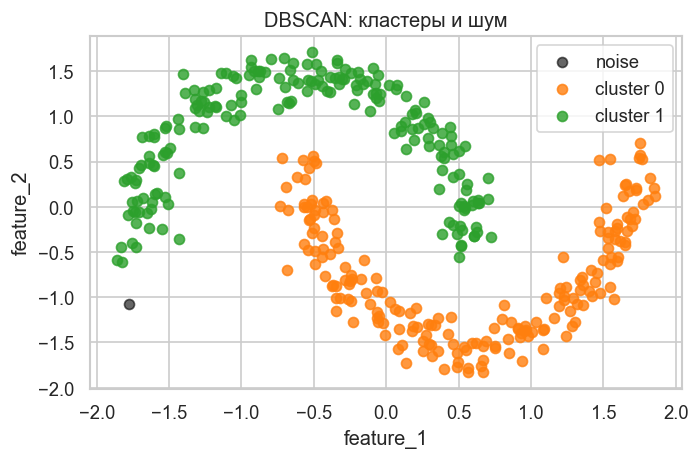

In [24]:
unique_labels = np.unique(labels)
colors = sns.color_palette("tab10", n_colors=len(unique_labels))

plt.figure(figsize=(6, 4))
for color, label in zip(colors, unique_labels):
    mask = labels == label
    if label == -1:
        plt.scatter(
            X_scaled[mask, 0],
            X_scaled[mask, 1],
            c="black",
            alpha=0.6,
            label="noise",
        )
    else:
        plt.scatter(
            X_scaled[mask, 0],
            X_scaled[mask, 1],
            color=color,
            alpha=0.8,
            label=f"cluster {label}",
        )

plt.title("DBSCAN: кластеры и шум")
plt.xlabel("feature_1")
plt.ylabel("feature_2")
plt.legend()
plt.tight_layout()
plt.show()
